In [1]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from pde import GenerateData, NeuralNet, LinearQuadraticRegulator2D
from tqdm import tqdm

In [2]:
generateData = GenerateData(domain=([0, 1], [0, 1]))

In [166]:
pointCount = 4
points = generateData.samplePoints(pointCount=pointCount).detach().numpy()
adjacent_points = generateData.samplePoints(pointCount=pointCount).detach().numpy()

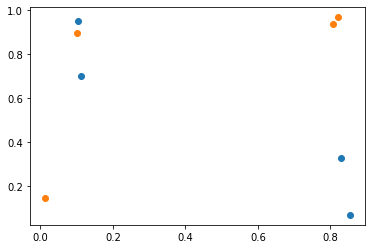

In [167]:
plt.scatter( points[:, 0], points[:, 1] )
plt.scatter( adjacent_points[:, 0], adjacent_points[:, 1] )

In [168]:
# Build matrix of distances between particles
from scipy.spatial.distance import cdist
cdist(points, adjacent_points)

array([[0.56643829, 0.75782623, 0.19425271, 0.73444346],
       [0.84299487, 0.90225419, 1.11984061, 0.87299126],
       [0.81017224, 0.71689297, 0.05316702, 0.70259038],
       [0.83632131, 0.64252595, 0.92573302, 0.61298765]])

In [394]:
layers = [2, 20, 1]
network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, positiveSolution=False)
gamma = {'matrix':0, 'residual':0, 'data':1, 'gradient':0}
lqr = LinearQuadraticRegulator2D(network=network, gamma=gamma, correctShift=False)

In [395]:
pointCount = 2000

# xData = generateData.samplePoints(pointCount=pointCount)
# yTrue = lqr.dataValueFunction(xData.detach())

# xAdjacentData = generateData.samplePoints(pointCount=pointCount)

In [396]:
gamma_adjacent = 0.

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

In [397]:
feedDict = {}
feedDict['xData'] = generateData.samplePoints(pointCount=pointCount)
feedDict['xEvaluation'] = generateData.sampleGrid(nPoint=100)

In [398]:
xData = feedDict['xData']
xEvaluation = feedDict['xEvaluation']
yTrue = lqr.dataValueFunction(xData.detach())

epochTotal = 0
info = []

for lr, iteration in zip(lrs, iterations):
    optimizer = torch.optim.Adam(params=network.model.parameters(), lr=lr)
        
    for epoch in range(iteration):
        yData = network.computeValueFunction(xData)
        # yAdjacentData = network.computeValueFunction(xAdjacentData)
        
        # compute loss and backpropagate
        lossData = torch.mean( (yData.double() - yTrue.double())**2 ).float()

        #distMatrix = cdist(yData.detach().numpy(), yAdjacentData.detach().numpy())
        #lossAdjacent = (yData - yAdjacentData).T @ torch.tensor(distMatrix).float() @ (yData - yAdjacentData)

        loss = lossData #+ gamma_adjacent * lossAdjacent

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        # print logs
        if (epochTotal % 100 == 0):
            print('%d / %d (%d / %d), lr:%.1e, loss:%.2e' % (
                epochTotal, sum(iterations), epoch, iteration, lr, loss
                )
            )

            yEvaluation = network.computeValueFunction(xEvaluation)
            yEvaluationTrue = lqr.dataValueFunction(xEvaluation).reshape(-1, 1)
            mse = torch.mean( (yEvaluation.double() - yEvaluationTrue.double())**2 ).float()


        epochTotal += 1
        info_dict = {
            'xData': xData,
            'epoch': epochTotal,
            'mse': mse.detach().cpu().numpy().item(),
            'loss': loss.detach().cpu().numpy().item()
            }
        info.append(info_dict)

info = pd.DataFrame( info )

0 / 3000 (0 / 1000), lr:1.0e-02, loss:3.27e+00
100 / 3000 (100 / 1000), lr:1.0e-02, loss:2.29e-02
200 / 3000 (200 / 1000), lr:1.0e-02, loss:1.01e-02
300 / 3000 (300 / 1000), lr:1.0e-02, loss:3.57e-03
400 / 3000 (400 / 1000), lr:1.0e-02, loss:1.80e-03
500 / 3000 (500 / 1000), lr:1.0e-02, loss:1.54e-03
600 / 3000 (600 / 1000), lr:1.0e-02, loss:1.51e-03
700 / 3000 (700 / 1000), lr:1.0e-02, loss:1.49e-03
800 / 3000 (800 / 1000), lr:1.0e-02, loss:1.47e-03
900 / 3000 (900 / 1000), lr:1.0e-02, loss:1.46e-03
1000 / 3000 (0 / 2000), lr:1.0e-03, loss:1.44e-03
1100 / 3000 (100 / 2000), lr:1.0e-03, loss:1.40e-03
1200 / 3000 (200 / 2000), lr:1.0e-03, loss:1.36e-03
1300 / 3000 (300 / 2000), lr:1.0e-03, loss:1.31e-03
1400 / 3000 (400 / 2000), lr:1.0e-03, loss:1.27e-03
1500 / 3000 (500 / 2000), lr:1.0e-03, loss:1.22e-03
1600 / 3000 (600 / 2000), lr:1.0e-03, loss:1.15e-03
1700 / 3000 (700 / 2000), lr:1.0e-03, loss:1.03e-03
1800 / 3000 (800 / 2000), lr:1.0e-03, loss:8.42e-04
1900 / 3000 (900 / 2000), lr

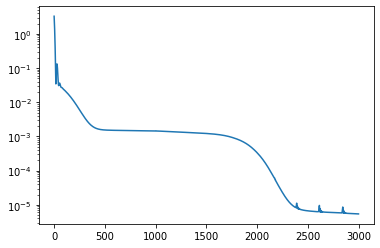

In [400]:
info['loss'].plot()
plt.yscale('log')

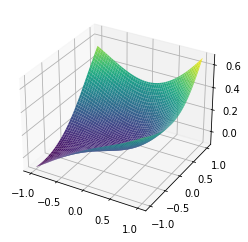

In [401]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');

# Reference

In [294]:
layers = [2, 20, 1]
network = NeuralNet(layers=layers, quadraticForm=False, useAdditionalModel=False, positiveSolution=False)

gamma = {'matrix':0, 'residual':0, 'data':1, 'gradient':1}
lqr = LinearQuadraticRegulator2D(network=network, gamma=gamma, correctShift=False)

In [295]:
lrs = [1e-3, 1e-4]
iterations = [500, 1000]

resu = lqr.train(interiorPointCount=100, dataPointCount=100, lrs=lrs, iterations=iterations, useTestData=False, verbose=True)

xInt:  torch.Size([100, 2])
xData:  torch.Size([100, 2])
0 / 1500 (0 / 500), lr:1.0e-03, loss:8.47e-01 (data: 6.84e-01, grad: 1.63e-01, res: 0.00e+00, mat: 0.00e+00)
100 / 1500 (100 / 500), lr:1.0e-03, loss:1.79e-01 (data: 1.88e-02, grad: 1.60e-01, res: 0.00e+00, mat: 0.00e+00)
200 / 1500 (200 / 500), lr:1.0e-03, loss:1.75e-01 (data: 1.78e-02, grad: 1.58e-01, res: 0.00e+00, mat: 0.00e+00)
300 / 1500 (300 / 500), lr:1.0e-03, loss:1.71e-01 (data: 1.73e-02, grad: 1.54e-01, res: 0.00e+00, mat: 0.00e+00)
400 / 1500 (400 / 500), lr:1.0e-03, loss:1.66e-01 (data: 1.66e-02, grad: 1.49e-01, res: 0.00e+00, mat: 0.00e+00)
500 / 1500 (0 / 1000), lr:1.0e-04, loss:1.58e-01 (data: 1.58e-02, grad: 1.43e-01, res: 0.00e+00, mat: 0.00e+00)
600 / 1500 (100 / 1000), lr:1.0e-04, loss:1.56e-01 (data: 1.57e-02, grad: 1.41e-01, res: 0.00e+00, mat: 0.00e+00)
700 / 1500 (200 / 1000), lr:1.0e-04, loss:1.55e-01 (data: 1.55e-02, grad: 1.39e-01, res: 0.00e+00, mat: 0.00e+00)
800 / 1500 (300 / 1000), lr:1.0e-04, loss:

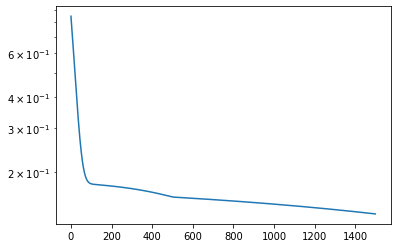

In [296]:
plt.plot( resu['loss'] )
plt.yscale('log')

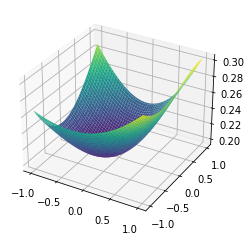

In [297]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = lqr.getEvaluationPoints()

Z = lqr.network.computeValueFunction(space).reshape(-1, 100)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');